In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
!pip install nilearn
!pip install nibabel
import nilearn as nl
import nibabel as nib

#import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
#!pip install git+https://github.com/rordenlab/niimath
#import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [ ]:
!unzip -u "/content/drive/My Drive/3dBrainTumorSegmentation/BraTS2020_TrainingData.zip" -d "/content/drive/My Drive/BRATSData/train"

Archive:  /content/drive/My Drive/3dBrainTumorSegmentation/BraTS2020_TrainingData.zip
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: /content/drive/My Drive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
angio=nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/angio_0_2.nii.gz').get_fdata()
print(angio.shape)

(350, 448, 160)


In [ ]:
angio2=nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/angio_0_1.nii.gz').get_fdata()
print(angio2.shape)
print(type(angio2))

(350, 448, 160)
<class 'numpy.ndarray'>


448


"#ax2.imshow(predBrain[predBrain.shape[0]//2-slice_w,:,:,2], cmap = 'gray')\n#ax2.set_title('test')\nplt.axis('off')\nplt.savefig('dingdong.png')\nax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')\nax2.set_title('Image t1')\nax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')\nax3.set_title('Image t1ce')\nax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')\nax4.set_title('Image t2')\nax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])\nax5.set_title('Mask')"

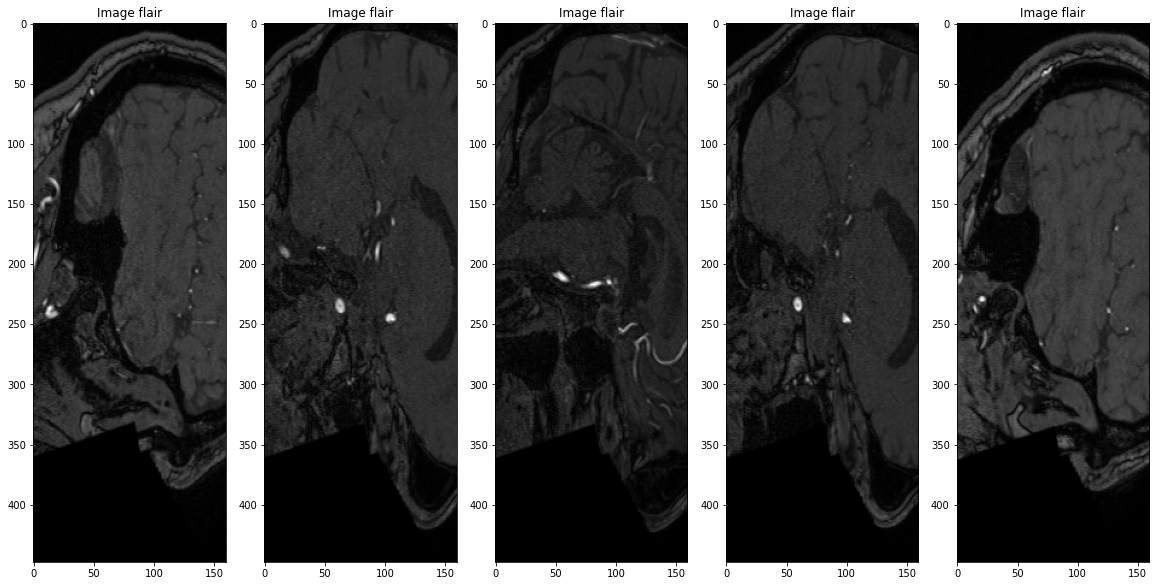

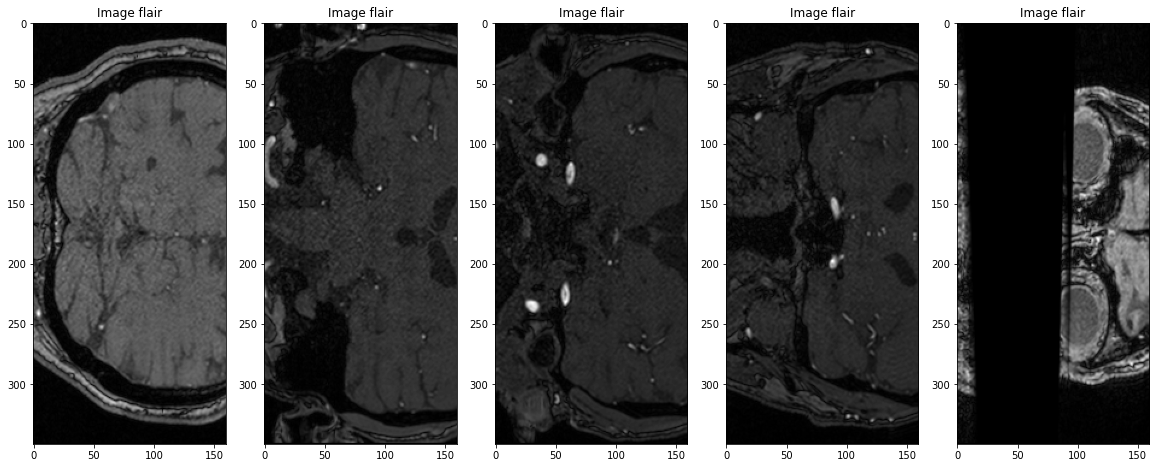

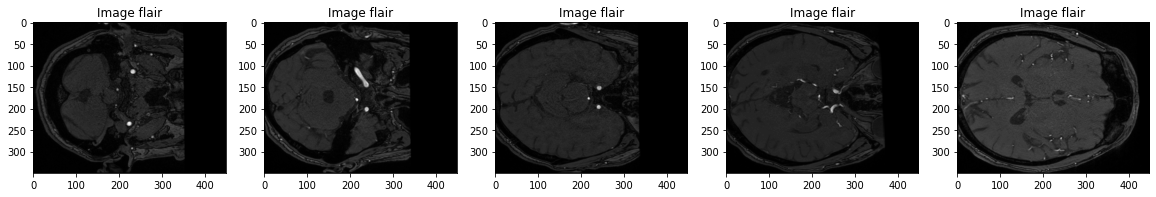

In [ ]:
'''
slice_w = 25
ax1.imshow(angio[:,:,10], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(angio[:,:,40], cmap = 'gray')
ax2.set_title('Image flair')
ax3.imshow(angio[:,:,70], cmap = 'gray')
ax3.set_title('Image flair')
ax4.imshow(angio[:,:,100], cmap = 'gray')
ax4.set_title('Image flair')
ax5.imshow(angio[:,:,130], cmap = 'gray')
ax5.set_title('Image flair')'''

def dispNii(nii, xyz):
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 20))
  if xyz == 'x':
    ax1.imshow(nii[round(nii.shape[0]*0.2),:,:], cmap = 'gray')
    ax1.set_title('Image flair')
    ax2.imshow(nii[round(nii.shape[0]*0.4),:,:], cmap = 'gray')
    ax2.set_title('Image flair')
    ax3.imshow(nii[round(nii.shape[0]*0.5),:,:], cmap = 'gray')
    ax3.set_title('Image flair')
    ax4.imshow(nii[round(nii.shape[0]*0.6),:,:], cmap = 'gray')
    ax4.set_title('Image flair')
    ax5.imshow(nii[round(nii.shape[0]*0.8),:,:], cmap = 'gray')
    ax5.set_title('Image flair')
  if xyz == 'y':
    ax1.imshow(nii[:,round(nii.shape[1]*0.2),:], cmap = 'gray')
    ax1.set_title('Image flair')
    ax2.imshow(nii[:,round(nii.shape[1]*0.4),:], cmap = 'gray')
    ax2.set_title('Image flair')
    ax3.imshow(nii[:,round(nii.shape[1]*0.5),:], cmap = 'gray')
    ax3.set_title('Image flair')
    ax4.imshow(nii[:,round(nii.shape[1]*0.6),:], cmap = 'gray')
    ax4.set_title('Image flair')
    ax5.imshow(nii[:,round(nii.shape[1]*0.8),:], cmap = 'gray')
    ax5.set_title('Image flair')
  if xyz == 'z':
    ax1.imshow(nii[:,:,round(nii.shape[2]*0.2)], cmap = 'gray')
    ax1.set_title('Image flair')
    ax2.imshow(nii[:,:,round(nii.shape[2]*0.4)], cmap = 'gray')
    ax2.set_title('Image flair')
    ax3.imshow(nii[:,:,round(nii.shape[2]*0.5)], cmap = 'gray')
    ax3.set_title('Image flair')
    ax4.imshow(nii[:,:,round(nii.shape[2]*0.6)], cmap = 'gray')
    ax4.set_title('Image flair')
    ax5.imshow(angio[:,:,round(nii.shape[2]*0.8)], cmap = 'gray')
    ax5.set_title('Image flair')
  
print(len(angio[2]))
dispNii(angio, 'x')
dispNii(angio, 'y')
dispNii(angio, 'z')


'''#ax2.imshow(predBrain[predBrain.shape[0]//2-slice_w,:,:,2], cmap = 'gray')
#ax2.set_title('test')
plt.axis('off')
plt.savefig('dingdong.png')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')'''

Text(0.5, 1.0, 'Image flair')

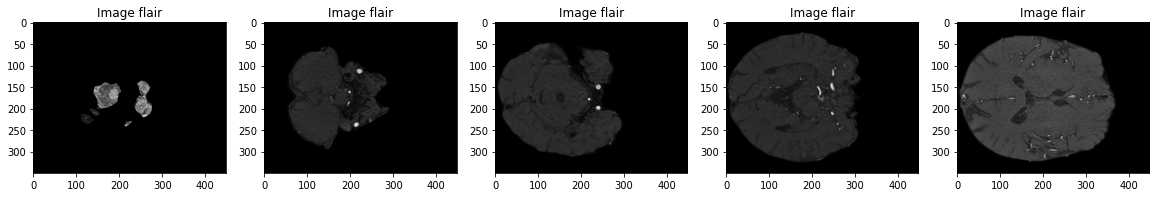

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(angio2[:,:,10], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(angio2[:,:,40], cmap = 'gray')
ax2.set_title('Image flair')
ax3.imshow(angio2[:,:,70], cmap = 'gray')
ax3.set_title('Image flair')
ax4.imshow(angio2[:,:,100], cmap = 'gray')
ax4.set_title('Image flair')
ax5.imshow(angio2[:,:,130], cmap = 'gray')
ax5.set_title('Image flair')


(448, 448, 128)


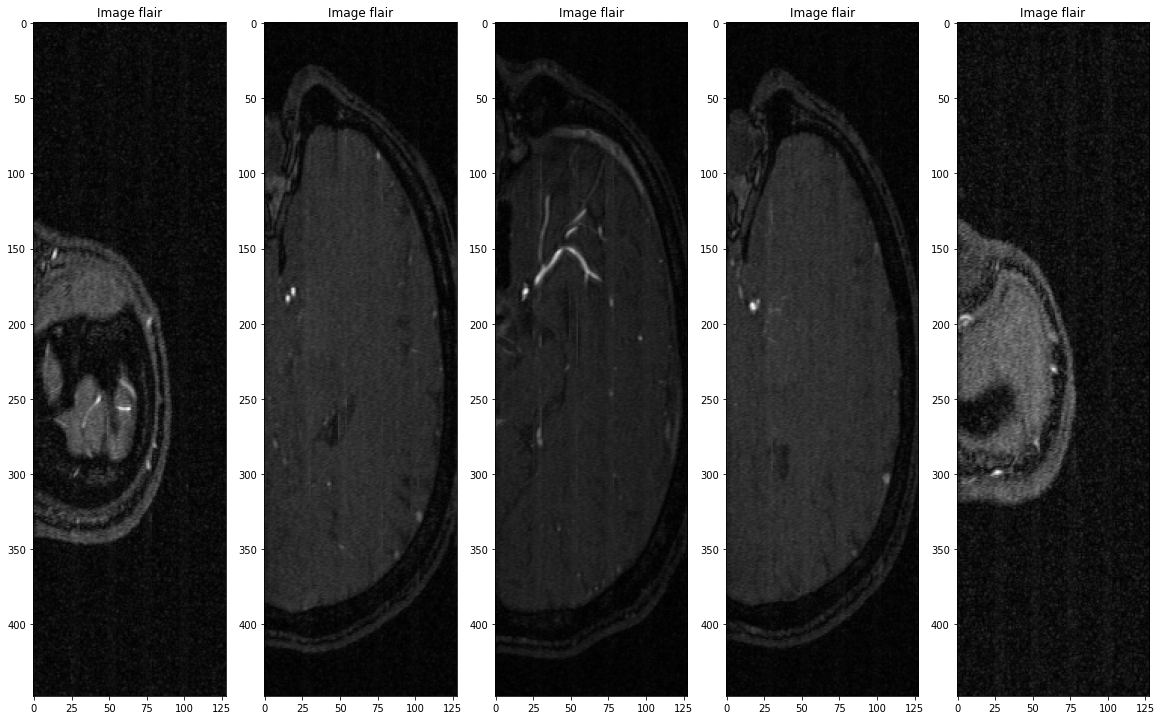

In [ ]:
tubetkmra=nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/train002.nii').get_fdata()
print(tubetkmra.shape)
dispNii(tubetkmra, 'x')

(448, 448, 128)


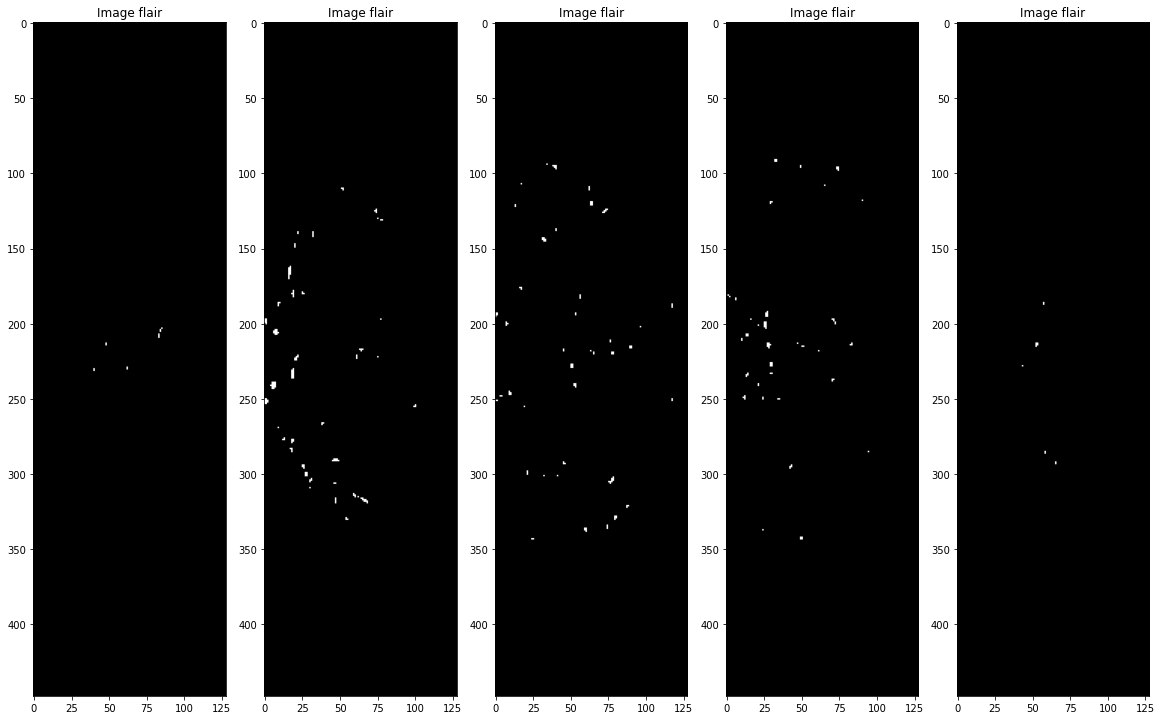

In [ ]:
tubetkmra=nib.load('label002.nii').get_fdata()
print(tubetkmra.shape)
dispNii(tubetkmra, 'y')

In [ ]:
!pip install SimpleITK
import SimpleITK as sitk


mha_image = sitk.ReadImage('/content/drive/MyDrive/3dBrainTumorSegmentation/cervascsegtest/predict/pred/train063_prednew.mha')
mha_label = sitk.ReadImage('/content/drive/MyDrive/3dBrainTumorSegmentation/cervascsegtest/predict/label/Normal063.mha')

sitk.WriteImage(mha_image, 'pred.nii')
sitk.WriteImage(mha_label, 'predlabel.nii')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(448, 448, 128)
(448, 448, 128)


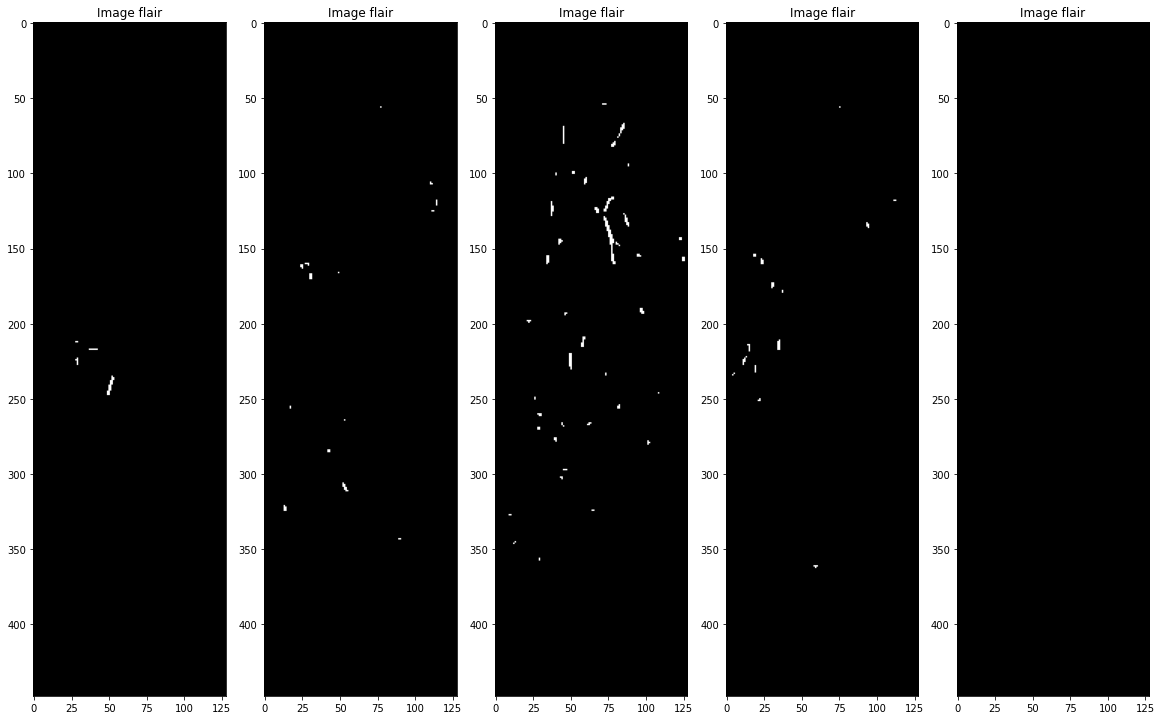

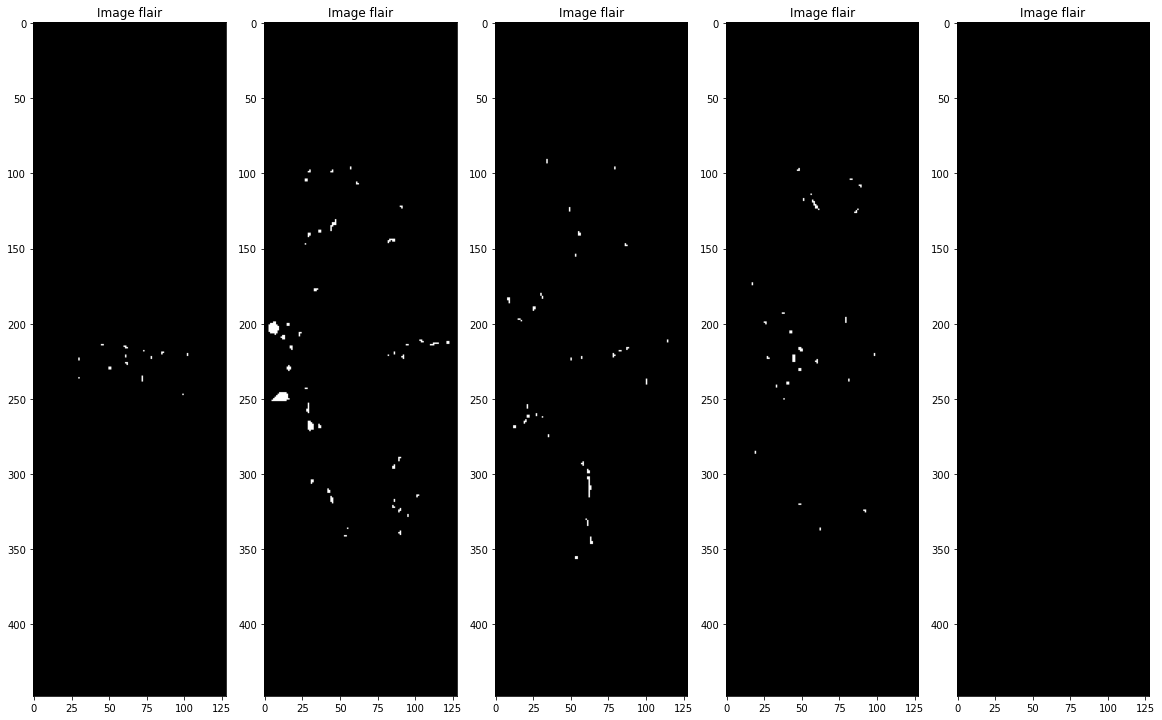

In [ ]:
mhapred=nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/cervascsegtest/predict/pred/pleasework.nii').get_fdata()
mhalabel=nib.load('predlabel.nii').get_fdata()
print(mhapred.shape)
print(mhalabel.shape)
dispNii(mhapred, 'x')
dispNii(mhalabel, 'y')

In [ ]:
predBrain=nib.load('').get_fdata()
print(predBrain.shape)
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
print(test_mask.shape)

(100, 128, 128, 4)
(240, 240, 155)


(100, 128, 128)
(240, 240, 155)


Text(0.5, 1.0, 'enhancing')

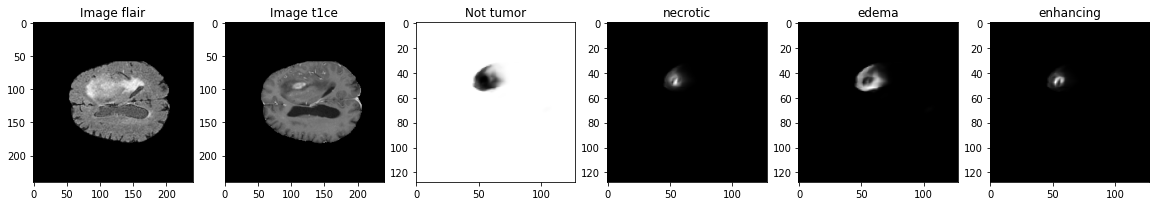

In [ ]:
'''nottumor = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/brainpred1').get_fdata()
necrotic = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/brainpred2').get_fdata()
edema = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/brainpred3').get_fdata()
enhancing = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/brainpred4').get_fdata()
ogflair = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/ogflair').get_fdata()
ogce = nib.load('/content/drive/MyDrive/3dBrainTumorSegmentation/data/ogce').get_fdata()'''

nottumor = nib.load('/content/brainpred1.nii').get_fdata()
necrotic = nib.load('/content/brainpred2.nii').get_fdata()
edema = nib.load('/content/brainpred3.nii').get_fdata()
enhancing = nib.load('/content/brainpred4.nii').get_fdata()
ogflair = nib.load('/content/ogflair.nii').get_fdata()
ogce = nib.load('/content/ogce.nii').get_fdata()

#print(necrotic.shape)
#print(ogflair.shape)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize = (20, 10))
slice_w = 25

ax1.imshow(ogflair[:,:,ogflair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')

ax2.imshow(ogce[:,:,ogce.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1ce')

ax3.imshow(nottumor[nottumor.shape[0]//2-slice_w,:,:], cmap = 'gray')
ax3.set_title('Not tumor')

ax4.imshow(necrotic[necrotic.shape[0]//2-slice_w,:,:], cmap = 'gray')
ax4.set_title('necrotic')

ax5.imshow(edema[edema.shape[0]//2-slice_w,:,:,], cmap = 'gray')
ax5.set_title('edema')

ax6.imshow(enhancing[enhancing.shape[0]//2-slice_w,:,:,], cmap = 'gray')
ax6.set_title('enhancing')



In [ ]:
print(necrotic[necrotic.shape[0]//2-slice_w,75,75])

NameError: ignored

In [ ]:
range = np.ptp(nottumor)
print(range)

0.9912086613476276


In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/BRATSData/train/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/BRATSData/val/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


'''
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
#ax2.imshow(predBrain[predBrain.shape[0]//2-slice_w,:,:,2], cmap = 'gray')
#ax2.set_title('test')
plt.axis('off')
plt.savefig('dingdong.png')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')'''


"\nfig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))\nslice_w = 25\nax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')\nax1.set_title('Image flair')\n#ax2.imshow(predBrain[predBrain.shape[0]//2-slice_w,:,:,2], cmap = 'gray')\n#ax2.set_title('test')\nplt.axis('off')\nplt.savefig('dingdong.png')\nax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')\nax2.set_title('Image t1')\nax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')\nax3.set_title('Image t1ce')\nax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')\nax4.set_title('Image t2')\nax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])\nax5.set_title('Mask')"

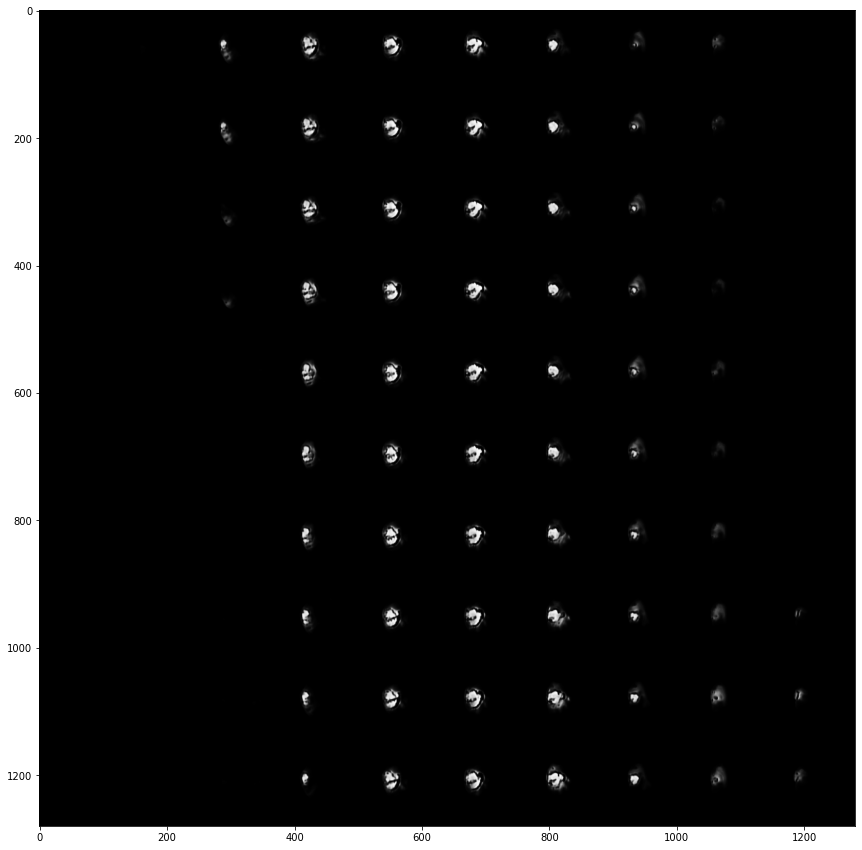

In [ ]:

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(predBrain[:,:,:,1]), 90, resize=True), cmap ='gray')

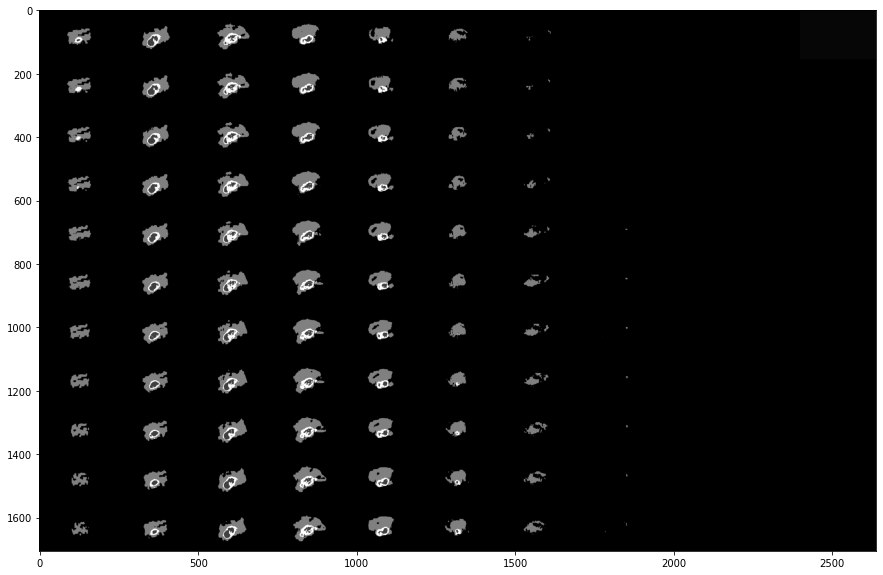

In [ ]:

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [ ]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')
shutil.copy2('/content/brainpred.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

ValueError: ignored

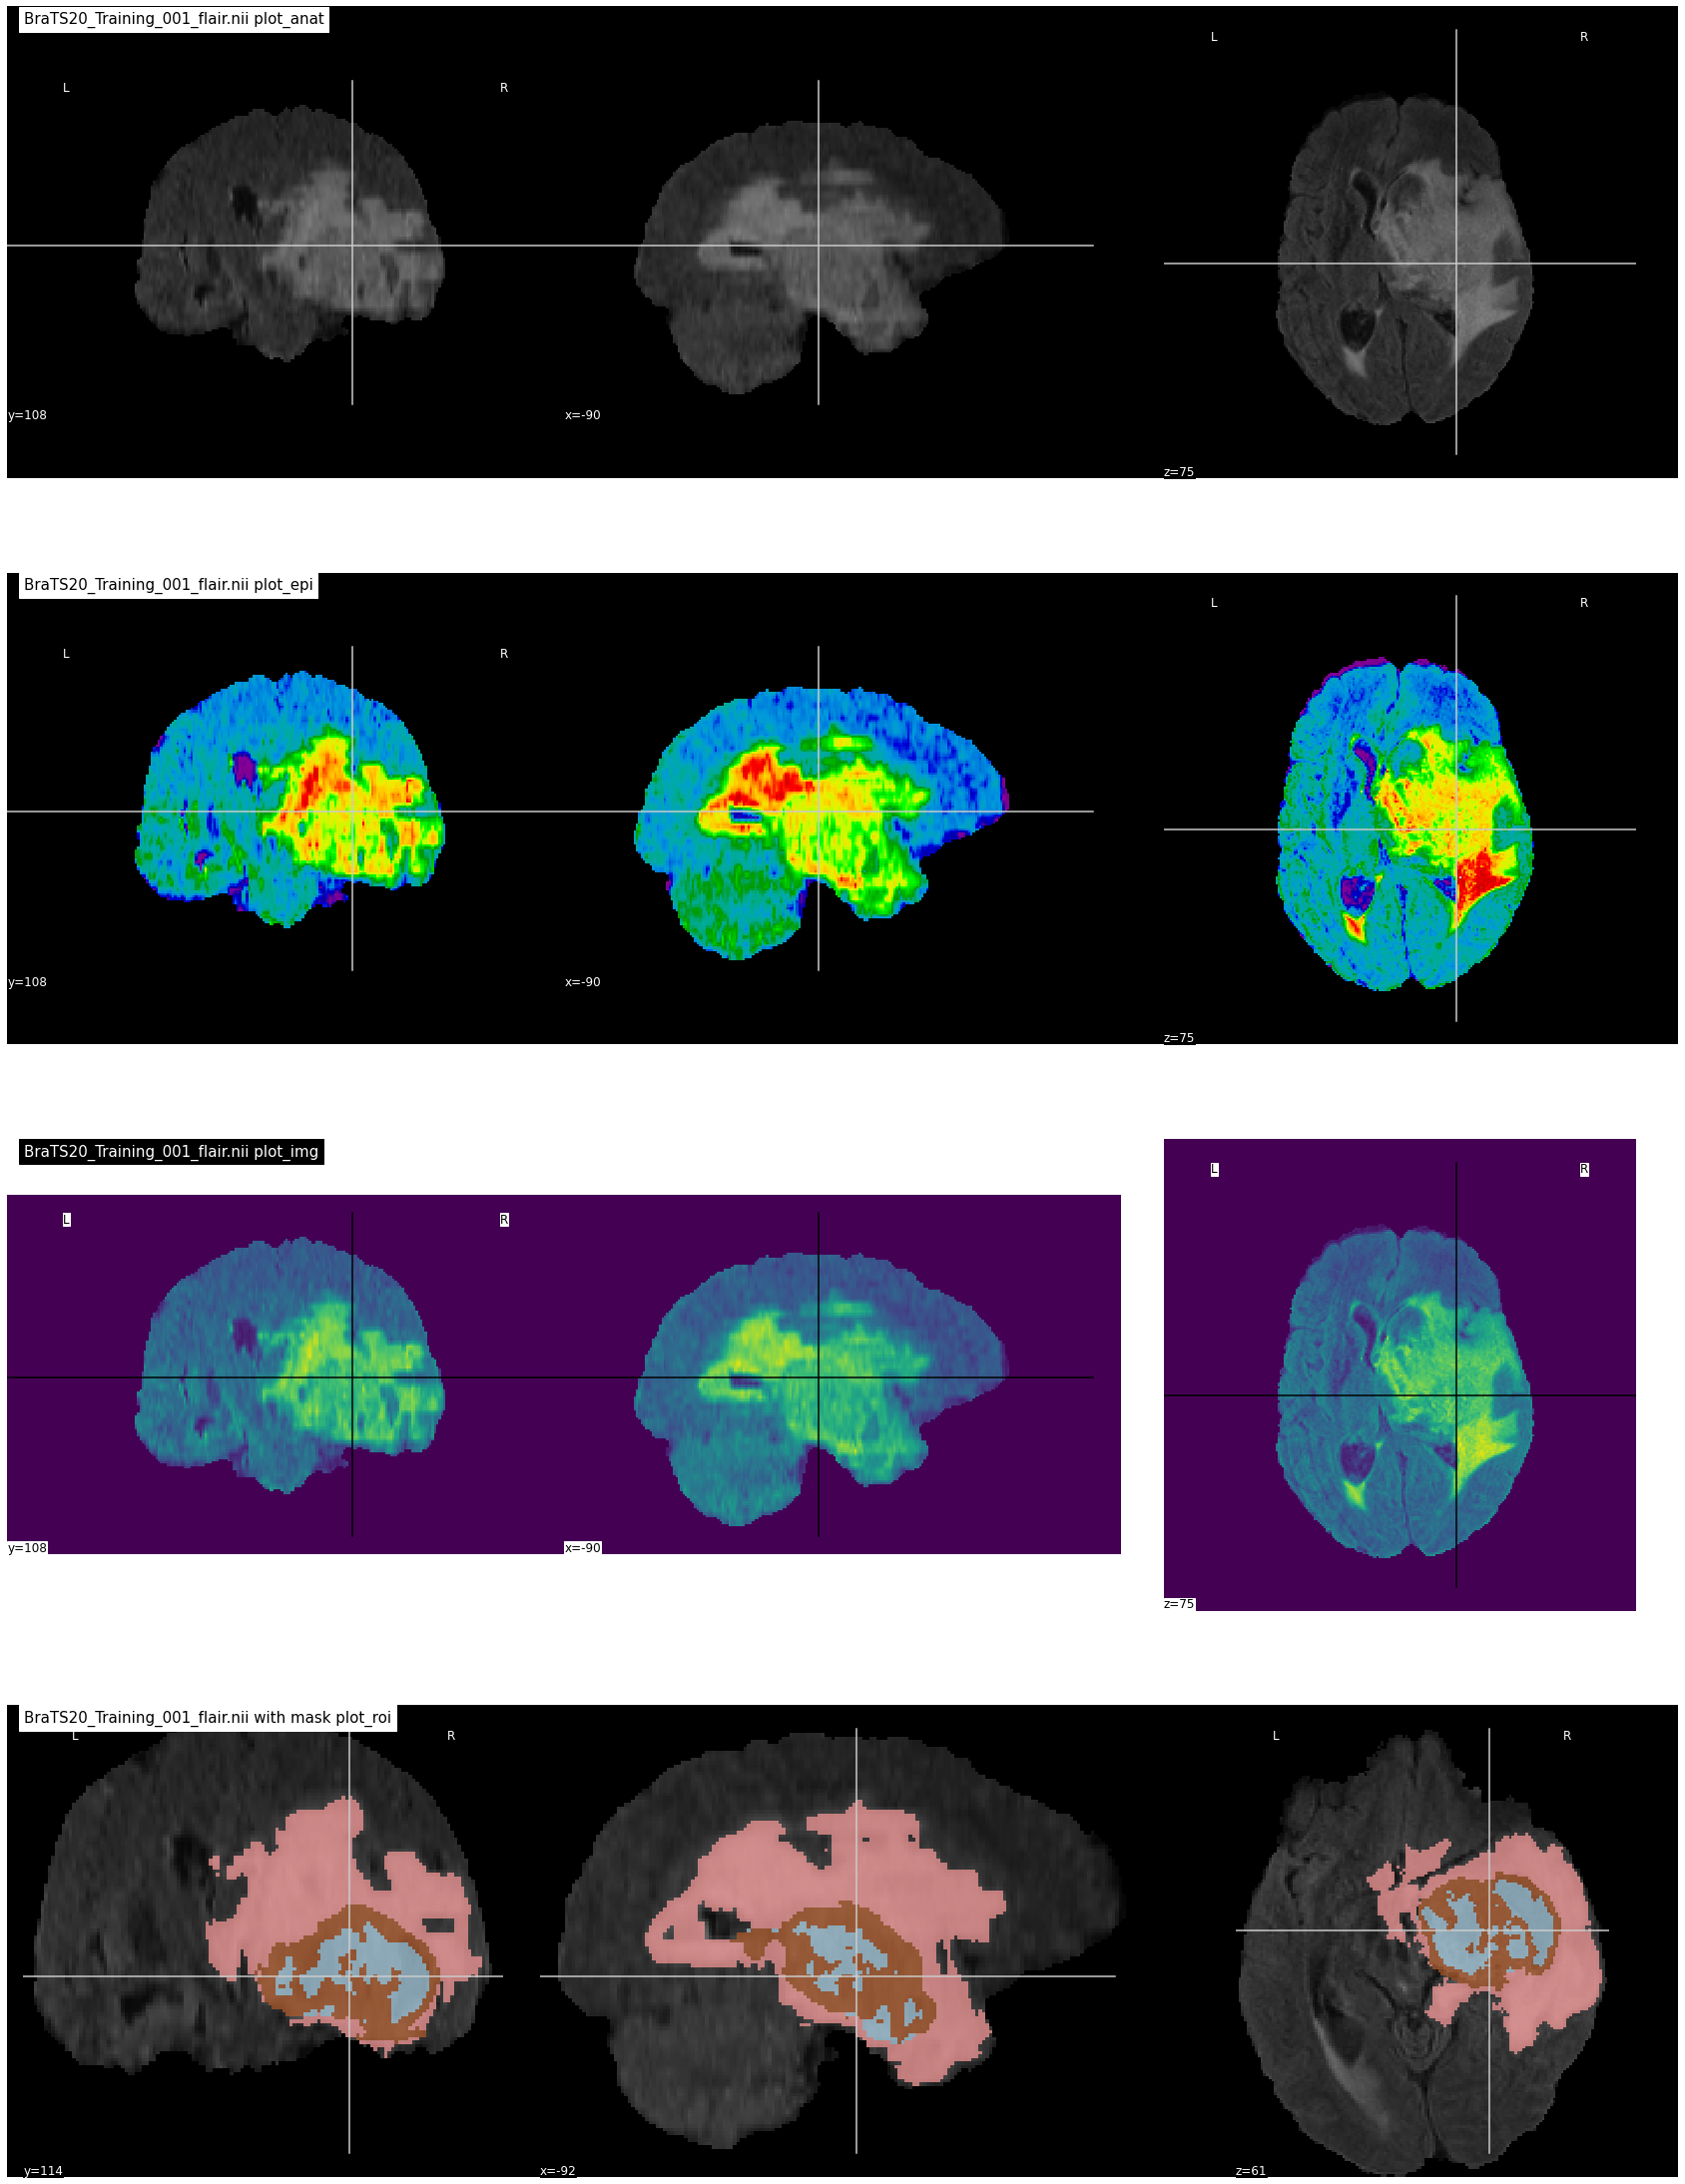

In [ ]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [ ]:
global globpred
global globtrue
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    globpred=y_pred
    globtrue=y_true
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    #K.print_tensor(intersection, message=' true positives necrotic')
    #K.print_tensor(K.sum(K.square(y_true[:,:,:,1]))-intersection, message=' true positives necrotic')
    #K.print_tensor(K.sum(K.square(y_pred[:,:,:,1]))-intersection, message=' true positives necrotic')
    
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    #K.print_tensor(intersection, message=' true positives edema')
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    #K.print_tensor(intersection, message=' true positives enhancing')
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        K.print_tensor(true_positives, message=' true positives ')
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        #K.print_tensor(predicted_positives-true_positives, message=' false positives ')
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    #K.print_tensor(true_positives, message=' true positives ')
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    #K.print_tensor(true_negatives, message=' true negatives ')
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    #K.print_tensor(possible_negatives-true_negatives, message=' false negatives ')
    return true_negatives / (possible_negatives + K.epsilon())
def print_fpclass(y_true, y_pred):
    true_positives0 = K.sum(K.round(K.clip(y_true[:,:,:,1] * y_pred[:,:,:,1], 0, 1)))
    true_positives1 = K.sum(K.round(K.clip(y_true[:,:,:,2] * y_pred[:,:,:,2], 0, 1)))
    true_positives2 = K.sum(K.round(K.clip(y_true[:,:,:,3] * y_pred[:,:,:,3], 0, 1)))
    K.print_tensor(true_positives0, message=' true positives necrotic')
    K.print_tensor(true_positives1, message=' true positives edema')
    K.print_tensor(true_positives2, message=' true positives enhancing')
    predicted_positives0 = K.sum(K.round(K.clip(y_pred[:,:,:,1], 0, 1)))
    predicted_positives1 = K.sum(K.round(K.clip(y_pred[:,:,:,2], 0, 1)))
    predicted_positives2 = K.sum(K.round(K.clip(y_pred[:,:,:,3], 0, 1)))
    K.print_tensor(predicted_positives0-true_positives0, message=' false positives necrotic')
    K.print_tensor(predicted_positives1-true_positives1, message=' false positives edema')
    K.print_tensor(predicted_positives2-true_positives2, message=' false positives enhancing')
    true_negatives0 = K.sum(K.round(K.clip((1-y_true[:,:,:,1]) * (1-y_pred[:,:,:,1]), 0, 1)))
    true_negatives1 = K.sum(K.round(K.clip((1-y_true[:,:,:,2]) * (1-y_pred[:,:,:,2]), 0, 1)))
    true_negatives2 = K.sum(K.round(K.clip((1-y_true[:,:,:,3]) * (1-y_pred[:,:,:,3]), 0, 1)))
    K.print_tensor(true_negatives0, message=' true negatives necrotic')
    K.print_tensor(true_negatives1, message=' true negatives edema')
    K.print_tensor(true_negatives2, message=' true negatives enhancing')
    possible_negatives0 = K.sum(K.round(K.clip(1-y_true[:,:,:,1], 0, 1)))
    possible_negatives1 = K.sum(K.round(K.clip(1-y_true[:,:,:,2], 0, 1)))
    possible_negatives2 = K.sum(K.round(K.clip(1-y_true[:,:,:,3], 0, 1)))
    K.print_tensor(possible_negatives0-true_negatives0, message=' false negatives necrotic')
    K.print_tensor(possible_negatives1-true_negatives1, message=' false negatives edema')
    K.print_tensor(possible_negatives2-true_negatives2, message=' false negatives enhancing')
    return true_positives0 / (predicted_positives0 + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

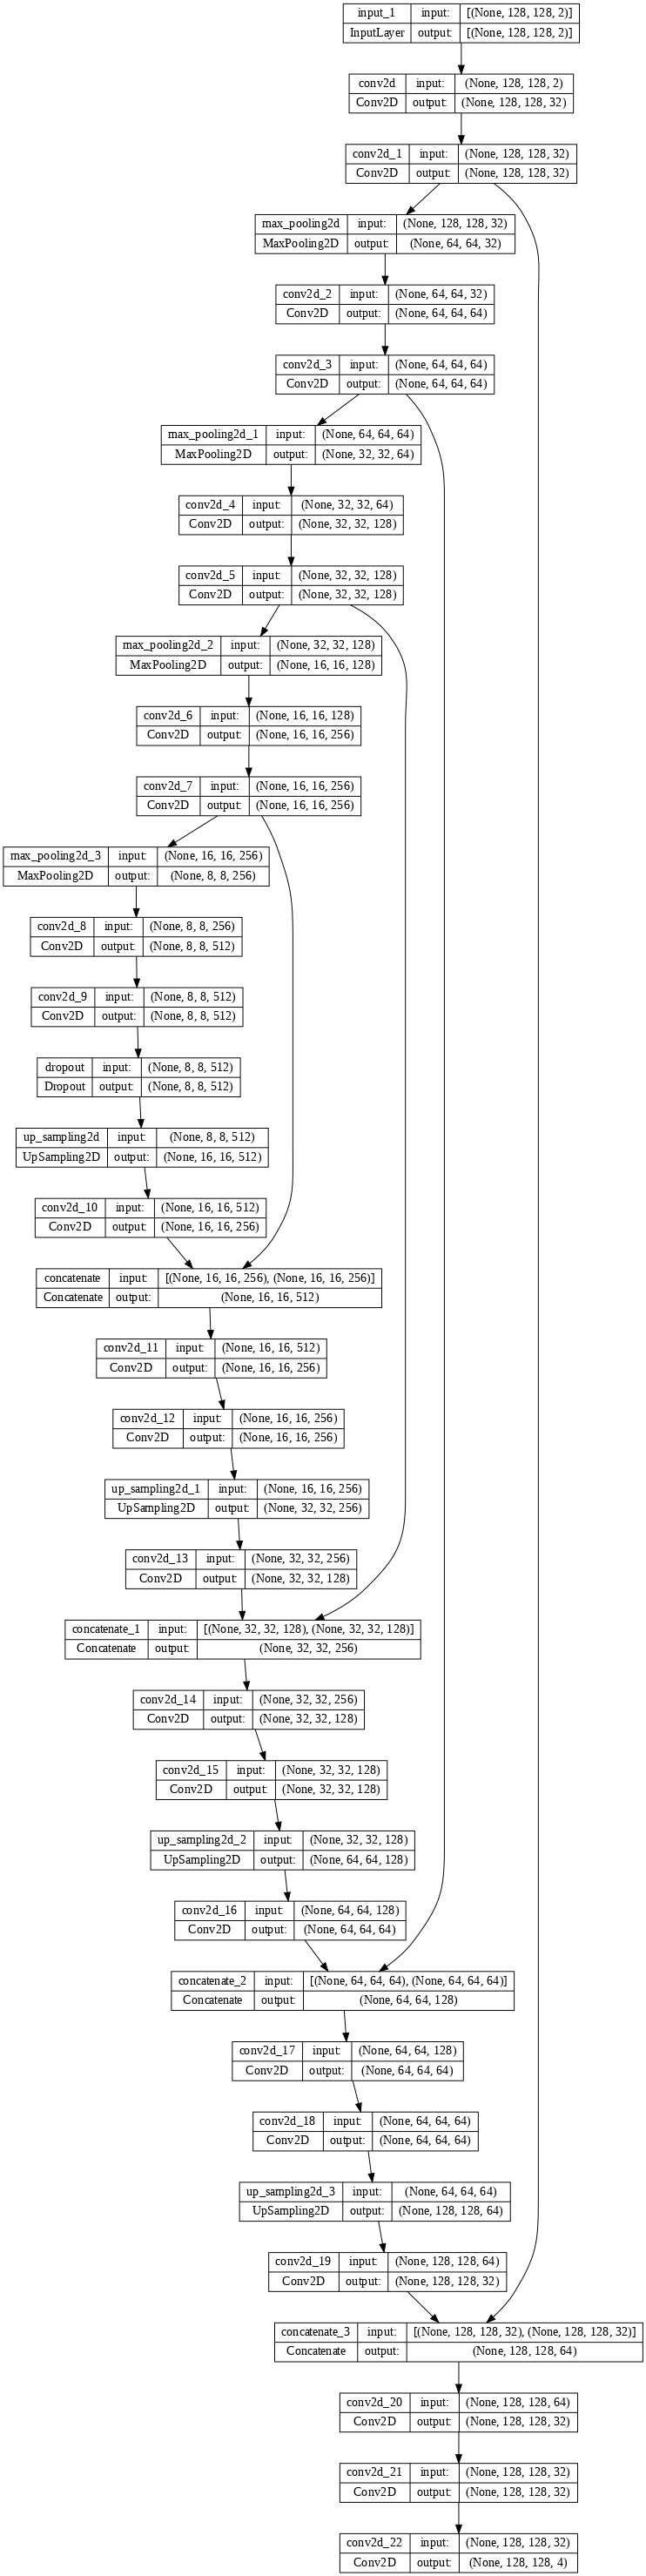

In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

45


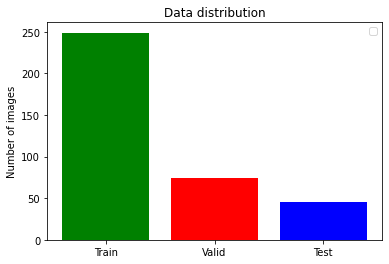

In [ ]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    print(len(test_ids))
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [ ]:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                     epochs=35,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model.save("model_x1_1.h5")

Epoch 1/35
249/249 [==============================] - 630s 2s/step - loss: 0.1103 - accuracy: 0.9762 - mean_io_u: 0.5044 - dice_coef: 0.2644 - precision: 0.9752 - sensitivity: 0.9711 - specificity: 0.9944 - dice_coef_necrotic: 0.0472 - dice_coef_edema: 0.1134 - dice_coef_enhancing: 0.0412 - val_loss: 0.0743 - val_accuracy: 0.9832 - val_mean_io_u: 0.4870 - val_dice_coef: 0.2820 - val_precision: 0.9829 - val_sensitivity: 0.9829 - val_specificity: 0.9943 - val_dice_coef_necrotic: 0.1037 - val_dice_coef_edema: 0.2414 - val_dice_coef_enhancing: 0.0844 - lr: 0.0010
Epoch 2/35
249/249 [==============================] - 64s 255ms/step - loss: 0.0733 - accuracy: 0.9832 - mean_io_u: 0.5429 - dice_coef: 0.2796 - precision: 0.9837 - sensitivity: 0.9817 - specificity: 0.9946 - dice_coef_necrotic: 0.0777 - dice_coef_edema: 0.1652 - dice_coef_enhancing: 0.0551 - val_loss: 0.0694 - val_accuracy: 0.9832 - val_mean_io_u: 0.5761 - val_dice_coef: 0.2980 - val_precision: 0.9865 - val_sensitivity: 0.9727 - 

In [ ]:
print(history)

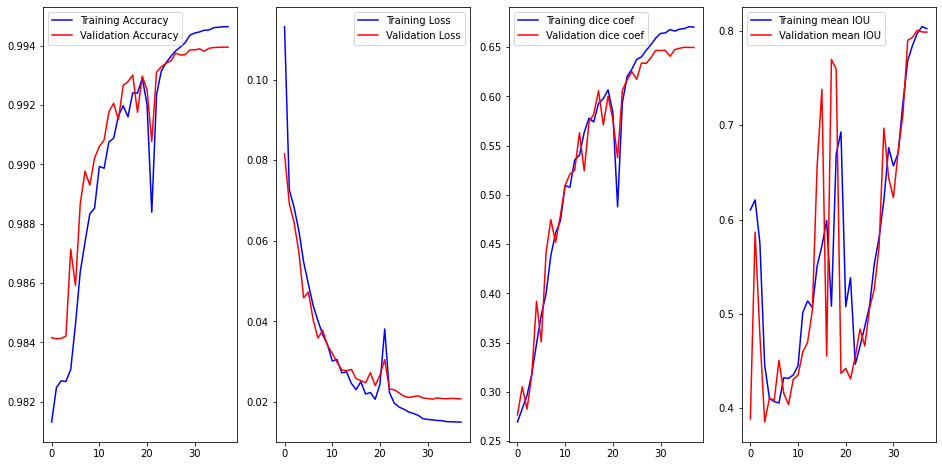

In [ ]:
############ load trained model ################
model = keras.models.load_model('/content/drive/MyDrive/3dBrainTumorSegmentation/bestmodels/model81.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/drive/MyDrive/3dBrainTumorSegmentation/bestmodels/model81.log', sep=',', engine='python')
history1 = pd.read_csv('/content/drive/MyDrive/3dBrainTumorSegmentation/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

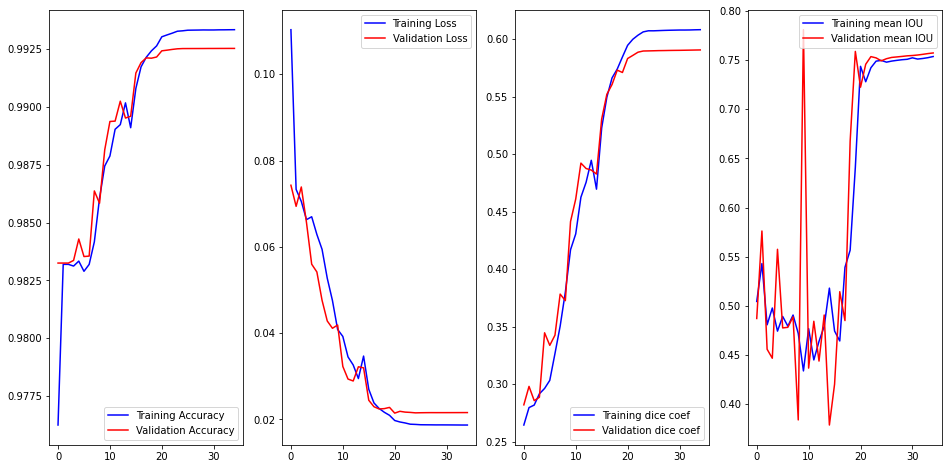

In [ ]:
hist=history1

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:

def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
       
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        



In [ ]:
%ls

drive/  model.png  model_x1_1.h5  sample_data/  training.log


4/4 [==============================] - 0s 79ms/step
(100, 128, 128, 4)
9.3476965e-06
2.787838e-06
0.0005458791
4.0649817e-09
(240, 240, 155)
(100, 128, 128)
(128, 128)


<Figure size 1296x3600 with 0 Axes>

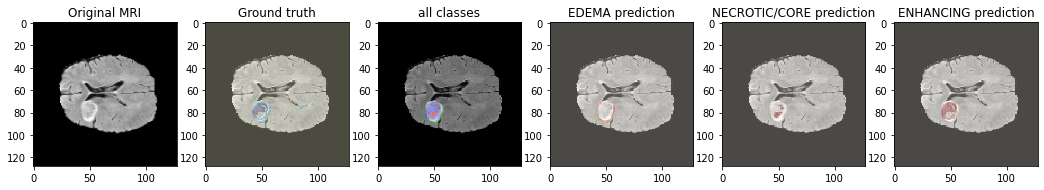

(100, 128, 128, 4)
(100, 128, 128, 4)
4/4 [==============================] - 0s 83ms/step
(100, 128, 128, 4)
0.00016162431
9.993699e-06
1.6451426e-05
5.8184996e-06
(240, 240, 155)
(100, 128, 128)
(128, 128)


<Figure size 1296x3600 with 0 Axes>

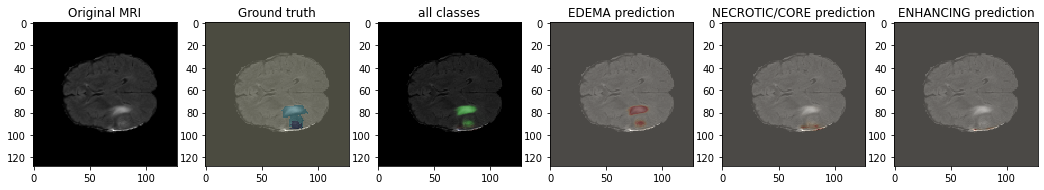

(100, 128, 128, 4)
(100, 128, 128, 4)
4/4 [==============================] - 0s 85ms/step
(100, 128, 128, 4)
5.010608e-06
1.1249952e-06
7.189669e-06
3.5488238e-06
(240, 240, 155)
(100, 128, 128)
(128, 128)


<Figure size 1296x3600 with 0 Axes>

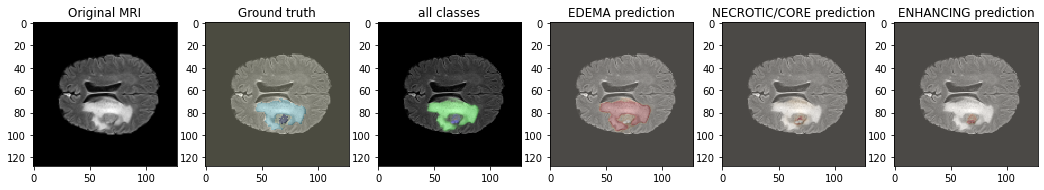

(100, 128, 128, 4)
(100, 128, 128, 4)


In [ ]:


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
 
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

        
 

    something = model.predict(X/np.max(X), verbose=1)
    '''
    ni_img1 = nib.Nifti1Image(something[:,:,:,0], affine=np.eye(4))
    ni_img2 = nib.Nifti1Image(something[:,:,:,1], affine=np.eye(4))
    ni_img3 = nib.Nifti1Image(something[:,:,:,2], affine=np.eye(4))
    ni_img4 = nib.Nifti1Image(something[:,:,:,3], affine=np.eye(4))
    ogflair = nib.Nifti1Image(flair, affine=np.eye(4))
    ogce = nib.Nifti1Image(ce, affine=np.eye(4))
    nib.save(ni_img1, "brainpred1.nii")
    nib.save(ni_img2, "brainpred2.nii")
    nib.save(ni_img3, "brainpred3.nii")
    nib.save(ni_img4, "brainpred4.nii")
    nib.save(ogflair, "ogflair.nii")
    nib.save(ogce, "ogce.nii")'''
    print(something.shape)
    print(something[70, 56, 50, 1])
    print(something[70, 50, 56, 1])
    print(something[70, 61, 49, 1])
    print(something[70, 50, 79, 1])
    return something

def showPredictsById(case, start_slice = 60):
    path = f"drive/MyDrive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)
    globpred=p
    globprob=p
    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]
    smth=p[:,:,:,0]
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): 
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original MRI')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    print(gt.shape)
    
    gt=cv2.resize(gt[:,:,20:120], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    gt = np.transpose(gt, (2, 1, 0))
    print(gt.shape)
    globtrue = np.zeros((gt.shape[0], gt.shape[1], gt.shape[2], 4))
    
    # Loop through the 3D array and set the appropriate index in the 4D binary array to 1
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            for k in range(gt.shape[2]):
                if gt[i, j, k] == 0:
                    globtrue[i, j, k, 0] = 1
                elif gt[i, j, k] == 1:
                    globtrue[i, j, k, 1] = 1
                elif gt[i, j, k] == 2:
                    globtrue[i, j, k, 2] = 1
                elif gt[i, j, k] == 4:
                    globtrue[i, j, k, 3] = 1
    print(curr_gt.shape)
    axarr[1].imshow(curr_gt, cmap="YlGnBu", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} prediction')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[1]} prediction')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} prediction')
    plt.show()
    print(globtrue.shape)
    print(globpred.shape)
    
    return globtrue, globpred, globprob
    
#globtrue, globpred, globprob = showPredictsById(case=test_ids[0][-3:])
#globtrue, globpred, globprob = showPredictsById(case=test_ids[1][-3:])
#globtrue, globpred, globprob = showPredictsById(case=test_ids[2][-3:])
#globtrue, globpred, globprob = showPredictsById(case=test_ids[3][-3:])
globtrue, globpred, globprob = showPredictsById(case=test_ids[4][-3:])
globtrue, globpred, globprob = showPredictsById(case=test_ids[5][-3:])
globtrue, globpred, globprob = showPredictsById(case=test_ids[6][-3:])

In [ ]:
print(type(something))

<class 'int'>


4/4 [==============================] - 9s 2s/step
(100, 128, 128, 4)
1.4381294e-05
2.679181e-07
0.00042998904
5.047364e-10
(240, 240, 155)


<Figure size 432x288 with 0 Axes>

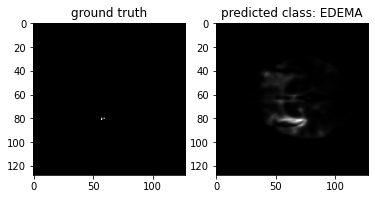

In [ ]:
case = case=test_ids[3][-3:]
#path = f"../drive/MyDrive/BRATSData/train/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
#gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
path = f"drive/MyDrive/BRATSData/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)
print(gt.shape)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
import tensorflow as tf
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
 true positives  1615178
45/45 [==============================] - 15s 278ms/step - loss: 0.0133 - accuracy: 0.9953 - mean_io_u_7: 0.7985 - dice_coef: 0.6936 - precision: 0.9954 - sensitivity: 0.9938 - specificity: 0.9984 - dice_coef_necrotic: 0.7472 - dice_coef_edema: 0.7944 - dice_coef_enhancing: 0.7929
test loss, test acc: [0.01328822411596775, 0.9952836632728577, 0.7984784841537476, 0.693562388420105, 0.9954190850257874, 0.9938390851020813, 0.9984385371208191, 0.7472350001335144, 0.7943611741065979, 0.7929369807243347]


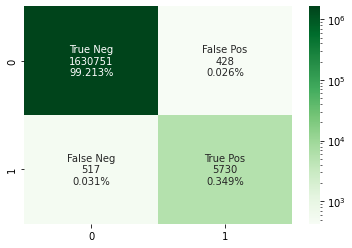

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm
cf_matrix=[[1630751,428],[517, 5730]]
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [1630751,428,517, 5730]
group_percentages = ['99.213%','0.026%','0.031%','0.349%']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens', norm=LogNorm()) #annot=labels

[0.    0.    0.    ... 0.997 0.998 1.   ]
[0.   0.   0.03 ... 1.   1.   1.  ]
[1.999 0.999 0.987 ... 0.    0.    0.   ]


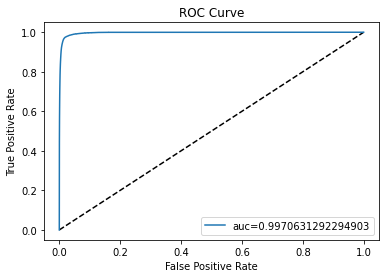

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import type_of_target
result = np.where(np.logical_and(globtrue<=0.9,globtrue>=0.1))
'''
for i,x in enumerate(globtrue):
    globtrue[i]=x.astype('int')
print(type(globtrue[0][0][0][1]))
#globtrue = np.array(globtrue, dtype=np.int)
print(type_of_target(globtrue))
cm = confusion_matrix(globtrue[:,:,:,1], globpred[:,:,:,1])
print(cm)'''
fpr, tpr, threshold = roc_curve(globtrue3, globpred3)
print(fpr)
print(tpr)
print(threshold)
plt.plot([0, 1], [0, 1], 'k--')
auc = roc_auc_score(globtrue3, globpred3)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':threshold})
index = np.argmax(gmean)
thresholdOpt = round(threshold[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.007000000216066837 with G-Mean: 0.9777
FPR: 0.0204, TPR: 0.9758


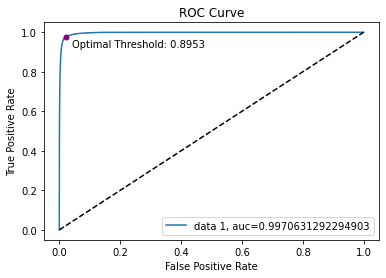

In [ ]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot(fprOpt, tprOpt, marker="o", markersize=5, markeredgecolor="purple", markerfacecolor="purple")
plt.text(fprOpt+0.02, tprOpt-0.05, "Optimal Threshold: 0.8953")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

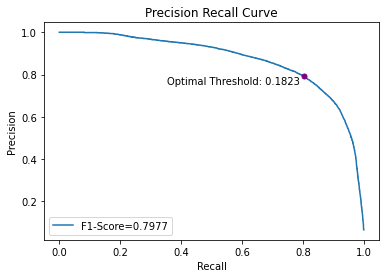

In [ ]:
plt.plot(recall,precision,label="F1-Score="+str(fscoreOpt))
plt.legend(loc=3)
plt.plot(recallOpt, precisionOpt, marker="o", markersize=5, markeredgecolor="purple", markerfacecolor="purple")
plt.text(recallOpt-0.45, precisionOpt-0.04, "Optimal Threshold: 0.1823") 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score   
precision, recall, thresholds = precision_recall_curve(globtrue3, globpred3)
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

Best Threshold: 0.18230000138282776 with F-Score: 0.7977
Recall: 0.8033, Precision: 0.792


In [ ]:
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

plt.plot(recall,precision,label="F1-Score="+str(fscoreOpt))
plt.legend(loc=3)
plt.plot(recallOpt, precisionOpt, marker="o", markersize=5, markeredgecolor="purple", markerfacecolor="purple")
plt.text(recallOpt+0.02, precisionOpt+0.05, "Optimal Threshold: 0.8540") 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [ ]:
globtrue3=globtrue3[:,:,:,2].flatten()
globpred3=globpred3[:,:,:,2].flatten()
#globpred3 = (globpred3 > 0.5).astype(np.int_)
print(globtrue3.shape)
print(globtrue3.shape)
cm = confusion_matrix(globtrue3, globpred3)

(1638400,)
(1638400,)


In [ ]:
def find_first_consecutive(arr):
    for i, x in enumerate(arr):
        if x == 1:
            # Check the next 9 elements
            if np.all(arr[i:i+10] == 1):
                return i
    return -1
print(find_first_consecutive(globtrue3))
print(find_first_consecutive(globpred3))

826422
809910


1


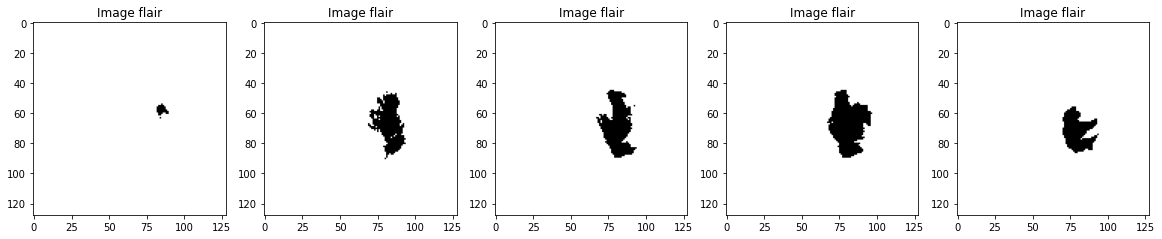

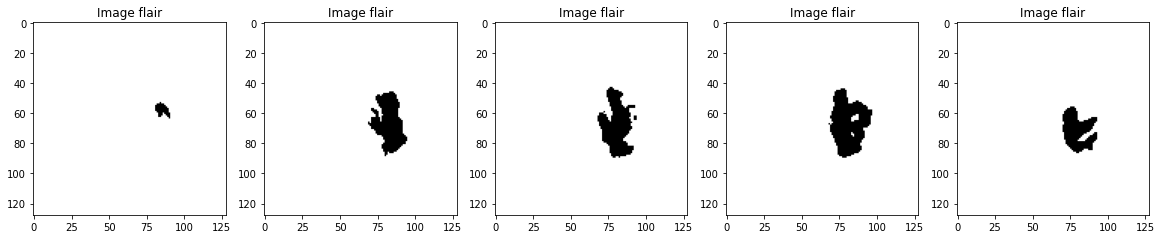

In [ ]:
globpred2 = np.transpose(globprob, (0, 2, 1, 3))
globpred2 = (globpred2[:,:,:,:] > 0.5).astype(np.int_)
globtrue2=globtrue.astype(np.int_)
dispNii(globtrue[:,:,:,0], 'x')
dispNii(globpred2[:,:,:,0], 'x')
print(globpred2[1,1,1,0])

In [ ]:
globtrue3=globtrue2
globpred3=globpred2

In [ ]:
ni_globtrue = nib.Nifti1Image(globtrue3[:,:,:,0], affine=np.eye(4), dtype='int64')
ni_globpred = nib.Nifti1Image(globpred3[:,:,:,0], affine=np.eye(4), dtype='int64')
nib.save(ni_globtrue, "/content/drive/MyDrive/tumtrue.nii")
nib.save(ni_globpred, "/content/drive/MyDrive/tumpred.nii")

In [ ]:
print(cm)

[[1615936     964]
 [  10210   11290]]


In [ ]:
from sklearn.metrics import confusion_matrix
"""Y_pred = model.predict_generator(test_generator, 45 // 100+1)
print(type(Y_pred))
print(Y_pred.shape)
print(np.amax(Y_pred))
print(np.amin(Y_pred))
y_true = np.array([0] * 50 + [1] * 50)
y_pred = Y_pred > 0.5"""
print(globtrue)
confusion_matrix(globtrue, globpred)

[[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0

ValueError: ignored

In [ ]:
def testfunct(true, pred):
  
  y_pred = np.argmax(pred axis=1)
  y_true = np.argmax(true, axis=1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def confusion_matrix(predictions, labels):
  # Flatten the predictions and labels arrays
  flat_predictions = predictions.argmax(axis=2).flatten()
  flat_labels = labels.argmax(axis=2).flatten()

  # Calculate the number of classes
  num_classes = predictions.shape[2]

  # Initialize the confusion matrix
  confusion_mat = np.zeros((num_classes, num_classes))

  # Loop over the predictions and labels and increment the confusion matrix
  for i in range(flat_predictions.shape[0]):
    confusion_mat[flat_predictions[i]][flat_labels[i]] += 1
  confusion_mat += 1e-12
  # Normalize the confusion matrix
  confusion_mat = confusion_mat / confusion_mat.sum(axis=1)[:, np.newaxis]

  return confusion_mat
e=confusion_matrix(p, gt)
print(e)
def visualize_confusion_matrix(confusion_matrix):
  # Create a figure and a subplot
  fig, ax = plt.subplots()

  # Create the heatmap
  sns.heatmap(confusion_matrix, annot=True, ax=ax)

  # Set the x-axis label
  ax.set_xlabel('Predicted labels')

  # Set the y-axis label
  ax.set_ylabel('True labels')

  # Set the title
  ax.set_title('Confusion Matrix')

  # Show the plot
  plt.show()



# Visualize the confusion matrix
visualize_confusion_matrix(e)

[[0.972 0.    0.    ... 0.    0.    0.   ]
 [0.96  0.    0.    ... 0.    0.    0.   ]
 [0.951 0.    0.    ... 0.    0.    0.   ]
 ...
 [0.008 0.008 0.008 ... 0.008 0.008 0.008]
 [1.    0.    0.    ... 0.    0.    0.   ]
 [0.938 0.    0.    ... 0.    0.    0.   ]]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
p=p[:,:,:,2]
p = p.transpose((1, 2, 0))
print(p[:,:,:,2].shape)
print(curr_gt.shape)
conf_mat = confusion_matrix(p[2], gt)

(100, 128, 128)
(128, 128, 155)


ValueError: ignored

In [ ]:
curr_gt=cv2.resize(gt[:,:,:], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
print(curr_gt.shape)

(128, 128, 155)


In [ ]:
testbratseg=nib.load("/content/drive/MyDrive/testbratseg.nii").get_fdata()
print(testbratseg.shape)
print(testbratseg[110][110][21])

(240, 240, 155)
0.0


In [ ]:
for i in range(curr_gt.shape[0]):
  for j in range(curr_gt.shape[1]):
    for k in range(curr_gt.shape[2]):
      if curr_gt[i, j, k] == 2:
        curr_gt[i, j, k] = 1
      else:
        curr_gt[i, j, k] = 0

In [ ]:
def betterconfusion_matrix(labels, predictions):
  # Convert the predictions and labels to 2D arrays
  predictions.numpy()
  labels.numpy()
  predictions = predictions.flatten()
  labels = labels.flatten()

  # Create a 4x4 matrix of zeros
  confusion_matrix = np.zeros((4,4))

  # Iterate over the predictions and labels and increment the corresponding element in the confusion matrix
  for prediction, label in zip(predictions, labels):
    confusion_matrix[prediction][label] += 1

  return confusion_matrix